In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import math
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold

In [3]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Elec/train.csv',encoding='cp949')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Elec/test.csv',encoding='cp949')
sample_sub = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Elec/sample_submission.csv',encoding='cp949')

In [6]:
train.head()

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0


In [7]:
test.head()

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,NaN,NaN
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-08-25 03,27.3,1.1,78.0,NaN,0.0,NaN,NaN
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   num         122400 non-null  int64  
 1   date_time   122400 non-null  object 
 2   전력사용량(kWh)  122400 non-null  float64
 3   기온(°C)      122400 non-null  float64
 4   풍속(m/s)     122400 non-null  float64
 5   습도(%)       122400 non-null  float64
 6   강수량(mm)     122400 non-null  float64
 7   일조(hr)      122400 non-null  float64
 8   비전기냉방설비운영   122400 non-null  float64
 9   태양광보유       122400 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 9.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10080 entries, 0 to 10079
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num           10080 non-null  int64  
 1   date_time     10080 non-null  object 
 2   기온(°C)        3360 non-null   float64


(None, None)

In [9]:
train.shape, test.shape

((122400, 10), (10080, 9))

In [10]:
train.isnull().sum(), test.isnull().sum()
## test 데이터 보간 필요 --- 전력량 예측하는데 문제 발생

(num           0
 date_time     0
 전력사용량(kWh)    0
 기온(°C)        0
 풍속(m/s)       0
 습도(%)         0
 강수량(mm)       0
 일조(hr)        0
 비전기냉방설비운영     0
 태양광보유         0
 dtype: int64, num                0
 date_time          0
 기온(°C)          6720
 풍속(m/s)         6720
 습도(%)           6720
 강수량(mm, 6시간)    8400
 일조(hr, 3시간)     6720
 비전기냉방설비운영       7784
 태양광보유           8456
 dtype: int64)

In [11]:
train[['num', '비전기냉방설비운영','태양광보유']]
ice={}
hot={}
count=0
for i in range(0, len(train), len(train)//60):
    count +=1
    ice[count]=train.loc[i,'비전기냉방설비운영']
    hot[count]=train.loc[i,'태양광보유']

In [12]:
for i in range(len(test)):
    test.loc[i, '비전기냉방설비운영']=ice[test['num'][i]]
    test.loc[i, '태양광보유']=hot[test['num'][i]]

In [13]:
def time(x):
    return int(x[-2:])
train['time']=train['date_time'].apply(lambda x: time(x))
test['time']=test['date_time'].apply(lambda x: time(x))

def weekday(x):
    return pd.to_datetime(x[:10]).weekday()
train['weekday']=train['date_time'].apply(lambda x :weekday(x))
test['weekday']=test['date_time'].apply(lambda x :weekday(x))

In [14]:
train.dtypes

num             int64
date_time      object
전력사용량(kWh)    float64
기온(°C)        float64
풍속(m/s)       float64
습도(%)         float64
강수량(mm)       float64
일조(hr)        float64
비전기냉방설비운영     float64
태양광보유         float64
time            int64
weekday         int64
dtype: object

In [15]:
test=test.interpolate(method='values')

In [16]:
test

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유,time,weekday
0,1,2020-08-25 00,27.800000,1.500000,74.000000,0.0,0.000000,0.0,0.0,0,1
1,1,2020-08-25 01,27.633333,1.366667,75.333333,0.0,0.000000,0.0,0.0,1,1
2,1,2020-08-25 02,27.466667,1.233333,76.666667,0.0,0.000000,0.0,0.0,2,1
3,1,2020-08-25 03,27.300000,1.100000,78.000000,0.0,0.000000,0.0,0.0,3,1
4,1,2020-08-25 04,26.900000,1.166667,79.666667,0.0,0.000000,0.0,0.0,4,1
...,...,...,...,...,...,...,...,...,...,...,...
10075,60,2020-08-31 19,28.633333,3.566667,66.000000,0.0,0.533333,1.0,1.0,19,0
10076,60,2020-08-31 20,28.266667,3.833333,67.000000,0.0,0.266667,1.0,1.0,20,0
10077,60,2020-08-31 21,27.900000,4.100000,68.000000,0.0,0.000000,1.0,1.0,21,0
10078,60,2020-08-31 22,27.900000,4.100000,68.000000,0.0,0.000000,1.0,1.0,22,0


In [17]:
check = train.iloc[:,3:]
for i in range(len(check.columns)):
  print(check.iloc[:,i].unique())

[17.6 17.7 17.5 17.1 17.  16.9 16.7 17.8 19.3 20.5 22.1 23.1 23.6 23.8
 24.4 22.7 21.3 19.8 18.6 17.9 17.2 16.6 16.2 15.9 15.7 15.5 14.8 15.
 16.  17.3 16.3 20.4 20.9 21.7 21.2 20.6 20.3 19.9 19.6 19.  18.4 18.3
 18.2 18.1 19.7 20.8 22.  26.1 26.8 27.9 28.2 28.1 21.  20.1 20.  22.4
 23.9 25.  26.  26.4 25.4 24.3 23.2 22.8 21.4 19.5 18.9 18.7 22.3 25.1
 26.3 27.2 27.8 28.5 28.6 25.8 21.1 20.7 19.4 19.2 24.  25.6 29.3 29.4
 30.5 30.6 29.1 27.1 25.2 24.8 23.4 27.4 28.4 28.9 28.  25.7 24.5 23.
 21.6 22.5 25.5 29.8 31.2 31.6 30.7 22.9 27.7 29.5 31.1 31.9 32.6 32.7
 32.5 30.  26.6 24.6 24.9 29.  30.3 31.  28.7 23.7 22.6 22.2 21.8 21.9
 24.2 25.9 29.2 30.2 31.3 31.4 23.3 23.5 26.5 27.3 27.  24.1 21.5 27.5
 33.1 33.  32.  29.7 26.9 19.1 18.8 20.2 30.4 29.6 24.7 27.6 29.9 25.3
 26.2 26.7 28.8 28.3 31.5 31.8 32.3 30.9 32.8 33.7 35.2 35.  31.7 30.8
 30.1 18.5 32.4 18.  32.1 32.2 16.1 15.2 14.6 14.1 13.6 13.8 13.9 13.2
 13.4 14.5 16.5 17.4 33.6 15.8 33.9 33.8 34.5 32.9 33.4 16.4 16.8 34.6
 34.1 33

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47141 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50857 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/bac

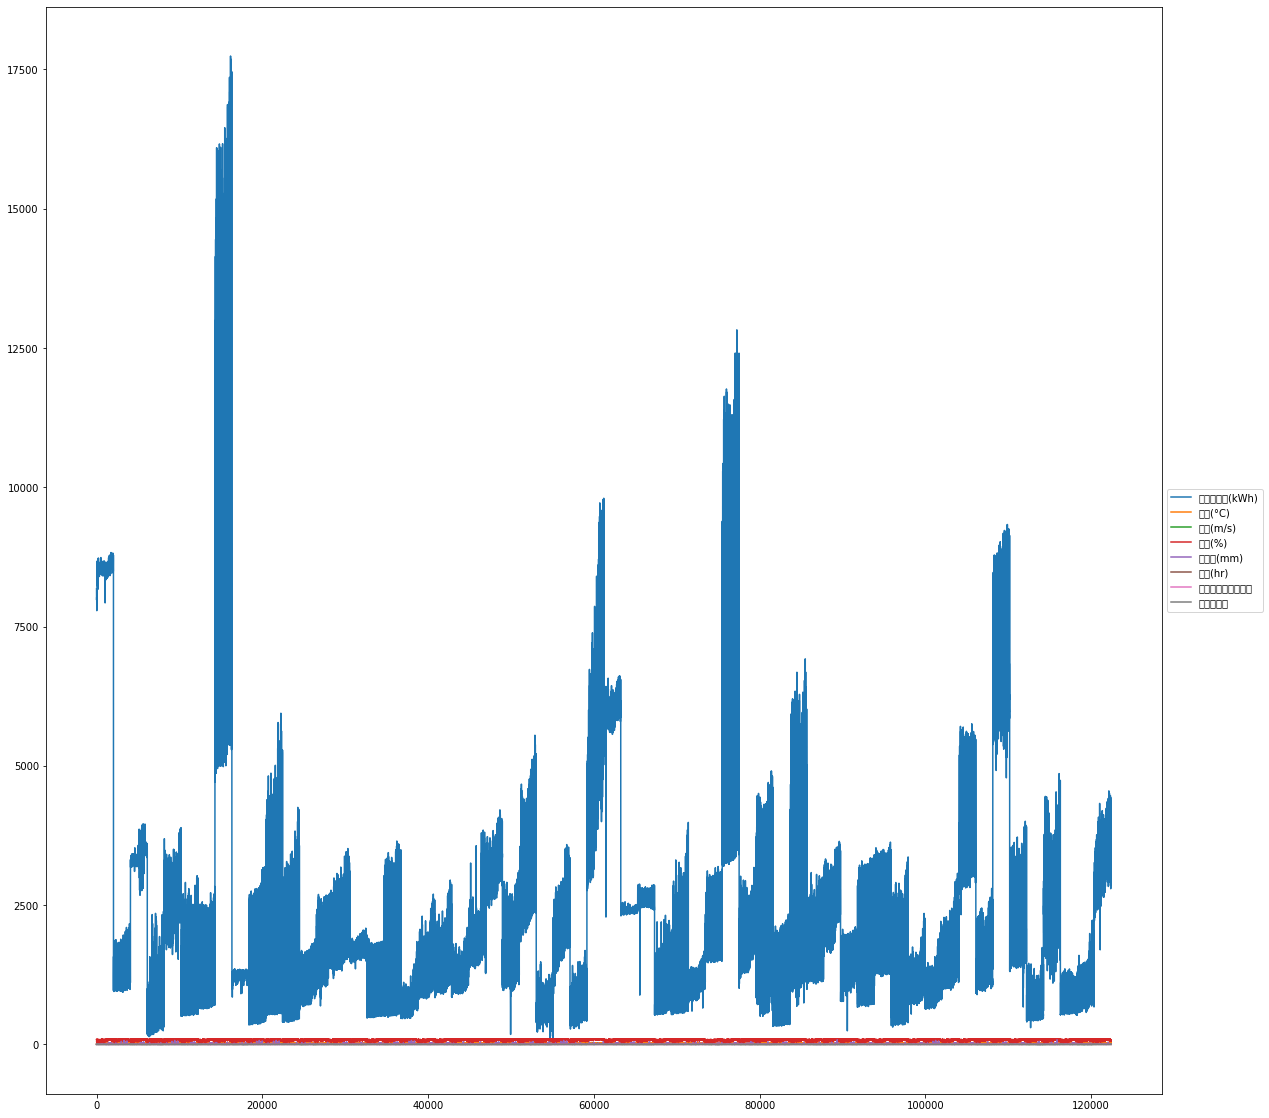

In [18]:
train.iloc[:,2:-2].plot(figsize=(20,20)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

In [19]:
train["비전기냉방설비운영"].unique(), train["태양광보유"].unique() # 각각 그룹화?? 굳이?

(array([0., 1.]), array([0., 1.]))

In [20]:
from sklearn.cluster import k_means
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

d_list = []
for i in range(1, 61):
    d = train[train['num'] == i].copy()
    d['전력사용량(kWh)'] = scaler.fit_transform(d['전력사용량(kWh)'].values.reshape(-1,1))
    d_ = d.groupby(['weekday', 'time'])['전력사용량(kWh)'].mean().unstack()
    d_list.append(d_.to_numpy())

d_list = np.array(d_list)

In [21]:
from sklearn.cluster import KMeans
d_list_ = d_list.reshape(60, -1)
model = KMeans(init="k-means++", n_clusters=4, random_state=0)
model.fit(d_list_)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [22]:
cluster = model.labels_
pd.DataFrame(cluster).value_counts()

1    31
2    17
3     7
0     5
dtype: int64

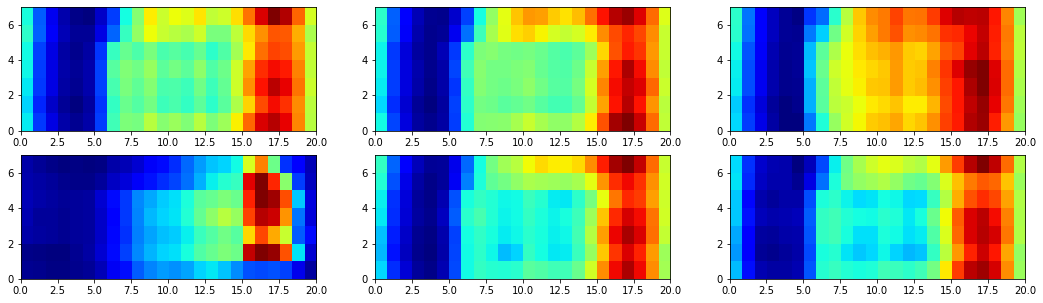

In [23]:
idx = cluster == 3
d_list = d_list.reshape(60, 7, 24)


fig, axes = plt.subplots(2, int(len(d_list[idx])/2), figsize = (18, 5))
axes = axes.flatten()

for d, ax in zip(d_list[idx], axes):
    d_ = scaler.inverse_transform(d)
    
    ax.imshow(d_, cmap = 'jet', aspect = 'auto', extent=[0, 20, 0, 7], origin = 'lower')

In [24]:
cluster_map = {i+1 : c for i, c in enumerate(cluster)}
train['cluster'] = train['num'].map(cluster_map)
test['cluster'] = test['num'].map(cluster_map)

In [25]:
X = train.drop(['date_time', '전력사용량(kWh)'], axis = 1)
y = train['전력사용량(kWh)']
X_test = test.drop('date_time', axis = 1)

In [26]:
X_test

,num,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유,time,weekday,cluster
0,1,27.800000,1.500000,74.000000,0.0,0.000000,0.0,0.0,0,1,0
1,1,27.633333,1.366667,75.333333,0.0,0.000000,0.0,0.0,1,1,0
2,1,27.466667,1.233333,76.666667,0.0,0.000000,0.0,0.0,2,1,0
3,1,27.300000,1.100000,78.000000,0.0,0.000000,0.0,0.0,3,1,0
4,1,26.900000,1.166667,79.666667,0.0,0.000000,0.0,0.0,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...
10075,60,28.633333,3.566667,66.000000,0.0,0.533333,1.0,1.0,19,0,2
10076,60,28.266667,3.833333,67.000000,0.0,0.266667,1.0,1.0,20,0,2
10077,60,27.900000,4.100000,68.000000,0.0,0.000000,1.0,1.0,21,0,2
10078,60,27.900000,4.100000,68.000000,0.0,0.000000,1.0,1.0,22,0,2


In [27]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.model_selection import StratifiedKFold

n_splits = 5
sfk = StratifiedKFold(n_splits = n_splits)
y_pred = np.zeros(len(X_test))

for tr_idx, val_idx in sfk.split(X, X['num']):      
    X_train = X.iloc[tr_idx, :]
    y_train = y[tr_idx]

    X_val = X.iloc[val_idx, :]
    y_val = y[val_idx]

    lgbm = LGBMRegressor(n_estimators = 10000, learning_rate= 0.1,objective = 'mse')
    lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric= 'rmse', early_stopping_rounds= 50,verbose = 100)
    y_pred += lgbm.predict(X_test) / n_splits

Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l2: 128049	valid_0's rmse: 357.839
[200]	valid_0's l2: 107240	valid_0's rmse: 327.475
[300]	valid_0's l2: 99553.6	valid_0's rmse: 315.521
[400]	valid_0's l2: 95411.8	valid_0's rmse: 308.888
[500]	valid_0's l2: 94164	valid_0's rmse: 306.861
[600]	valid_0's l2: 92410.5	valid_0's rmse: 303.991
[700]	valid_0's l2: 91282.1	valid_0's rmse: 302.129
[800]	valid_0's l2: 90522.4	valid_0's rmse: 300.869
[900]	valid_0's l2: 89520.6	valid_0's rmse: 299.2
[1000]	valid_0's l2: 88917.2	valid_0's rmse: 298.19
[1100]	valid_0's l2: 88297	valid_0's rmse: 297.148
Early stopping, best iteration is:
[1111]	valid_0's l2: 88249	valid_0's rmse: 297.067
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l2: 83031.1	valid_0's rmse: 288.151
[200]	valid_0's l2: 61161	valid_0's rmse: 247.308
[300]	valid_0's l2: 54848.2	valid_0's rmse: 234.197
[400]	valid_0's l2: 52518.6	valid_0's rmse: 229.169
[500]	valid_0's l2:

In [28]:
submission = sample_sub.copy()
submission['answer'] = y_pred

In [29]:
submission.to_csv('전력사용량_baseline_lgbm.csv', index= False)

In [30]:
pip install shap

In [31]:
def plot_feat_importance(reg, train):
    if hasattr(reg, 'feature_importances_'):
        importances = reg.feature_importances_
        features = train.columns
        feat_importances = pd.DataFrame()
        feat_importances["weight"] = importances
        feat_importances.index = features
        feat_importances.sort_values(by="weight", ascending=False)
        feat_importances.nlargest(30, ["weight"]).sort_values(by="weight").plot(kind='barh', title=f"top features", color='#86bf91', figsize=(10, 8))
        plt.show()

In [31]:
'''def plot_pimp(pimps, train):
    importances = pimps.importances_mean
    features = train.columns
    feat_importances = pd.DataFrame()
    feat_importances["weight"] = importances
    feat_importances.index = features
    feat_importances.sort_values(by="weight", ascending=False)
    feat_importances.nlargest(30, ["weight"]).sort_values(by="weight").plot(kind='barh', title=f"top features", color='#86bf91', figsize=(10, 8))
    plt.show()'''

In [32]:
import warnings

warnings.filterwarnings(action='ignore') 

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


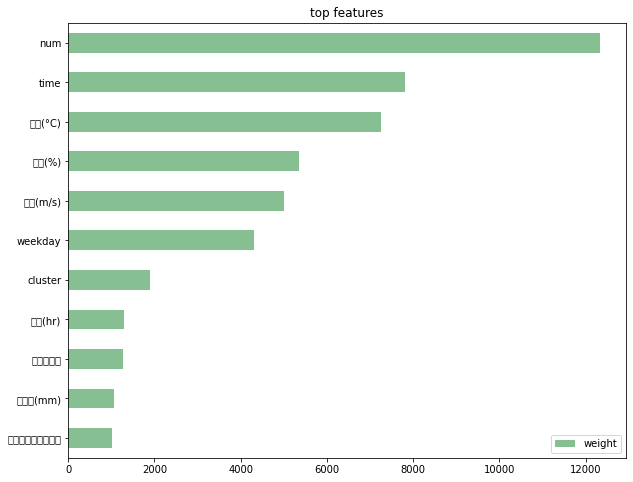

In [33]:
plot_feat_importance(lgbm, X_train)

In [42]:
X_test

,num,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유,time,weekday,cluster
0,1,27.800000,1.500000,74.000000,0.0,0.000000,0.0,0.0,0,1,0
1,1,27.633333,1.366667,75.333333,0.0,0.000000,0.0,0.0,1,1,0
2,1,27.466667,1.233333,76.666667,0.0,0.000000,0.0,0.0,2,1,0
3,1,27.300000,1.100000,78.000000,0.0,0.000000,0.0,0.0,3,1,0
4,1,26.900000,1.166667,79.666667,0.0,0.000000,0.0,0.0,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...
10075,60,28.633333,3.566667,66.000000,0.0,0.533333,1.0,1.0,19,0,2
10076,60,28.266667,3.833333,67.000000,0.0,0.266667,1.0,1.0,20,0,2
10077,60,27.900000,4.100000,68.000000,0.0,0.000000,1.0,1.0,21,0,2
10078,60,27.900000,4.100000,68.000000,0.0,0.000000,1.0,1.0,22,0,2


In [34]:
import shap
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_test)

In [37]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[1,:], X_test.iloc[1,:])

In [45]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0:1000,:], X_test.iloc[0:1000,:])

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


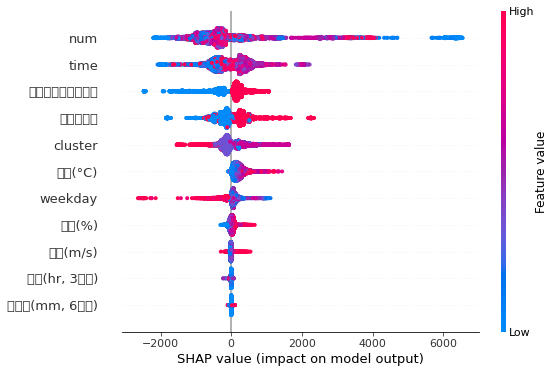

In [38]:
shap.summary_plot(shap_values, X_test)

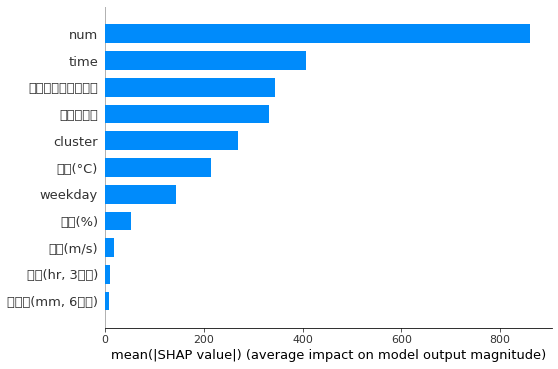

In [39]:
shap.summary_plot(shap_values, X_test, plot_type = "bar")

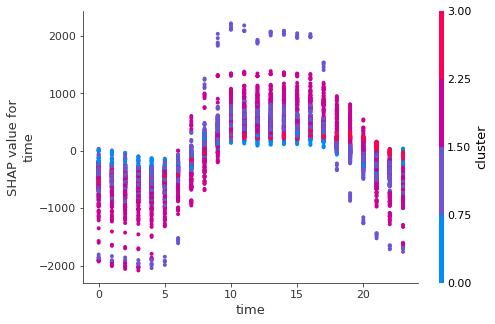

In [46]:
shap.dependence_plot("time", shap_values, X_test)

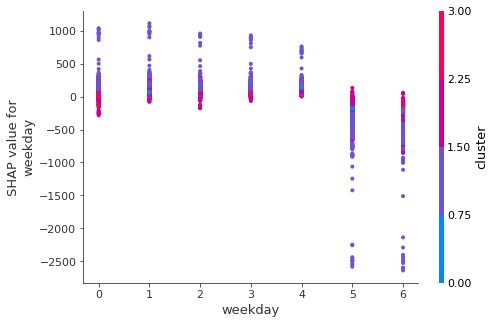

In [47]:
shap.dependence_plot("weekday", shap_values, X_test)

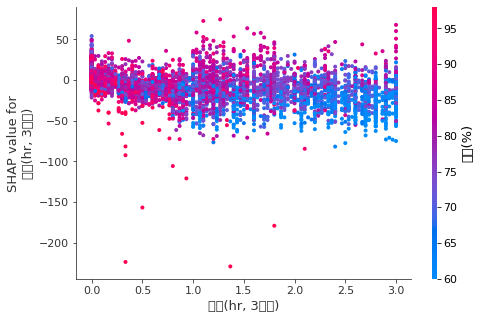

In [48]:
shap.dependence_plot("일조(hr, 3시간)", shap_values, X_test)